In [39]:
import gymnasium as gym
import numpy as np
import torch.nn as nn
from stable_baselines3 import DQN
from stable_baselines3.common.policies import BaseFeaturesExtractor
from stable_baselines3.dqn.policies import DQNPolicy
import pandas as pd
from tensorflow import keras
import os
from torch.utils.tensorboard import SummaryWriter

# Directory for TensorBoard logs
log_dir = "tensorboard_logs"
os.makedirs(log_dir, exist_ok=True)

In [40]:

# Constants
EPISODES = 100
TIMESTEPS = 25
HIGH_RISK_REWARD = 1
NORMAL_REWARD = -2

In [41]:
class CustomHighwayEnv(gym.Wrapper):
    def step(self, action):
        obs, reward, done,truncated, info = self.env.step(action)
        # Negatively reward the agent for staying in the same lane for too long
        if obs[0, 0] == obs[1, 0]:
            reward -= 0.1
        # Negatively reward the agent for driving too slowly
        if obs[0, 2] < 20:
            reward -= 0.1
        # Negatively reward the agent for tailgating other vehicles
        if obs[0, 1] < 0.5:
            reward -= 0.1

        # Penalize if controlled vehicles collide with each other
        # Extract (x, y) positions for the controlled vehicles
        controlled_vehicles_positions = [(obs[i][1], obs[i][0]) for i in range(2)]  # (x, y) for each vehicle
        collision_threshold = 1
        # Check for collisions
        for idx, pos1 in enumerate(controlled_vehicles_positions):
            for pos2 in controlled_vehicles_positions[idx + 1:]:
                x_diff = abs(pos1[0] - pos2[0])
                y_diff = abs(pos1[1] - pos2[1])
                
                if x_diff < collision_threshold and y_diff < collision_threshold:
                    #reward += (-HIGH_RISK_REWARD*3)
                    pass
                    #done = True
                    break
        if info["crashed"]:
            reward += 30
        else:
            reward += NORMAL_REWARD
        reward+= info["rewards"]["collision_reward"]
        return obs, reward, done,truncated, info

In [42]:
if __name__ == "__main__":
    # Create environment
    env = gym.make('merge-v0',render_mode="rgb_array")
    env.configure({"collision_reward" : HIGH_RISK_REWARD})
    env.configure({"lane_change_reward" : 1})
    env.configure({"vehicles_count" : 4})
    env.configure({"lanes_count" : 4})
    env.configure({"controlled_vehicles": 1})  # Control 3 vehicles
    env.configure({"vehicles_density": 1.5}) 
    env.configure({"reward_speed_range": [20,80]}) 
    env.configure({"right_lane_reward": 0}) 

    


    env = CustomHighwayEnv(env)

c:\Users\nagas\Python38\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


In [43]:
import pprint

pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': 1,
 'controlled_vehicles': 1,
 'high_speed_reward': 0.2,
 'lane_change_reward': 1,
 'lanes_count': 4,
 'manual_control': False,
 'merging_speed_reward': -0.5,
 'observation': {'type': 'Kinematics'},
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 80],
 'right_lane_reward': 0,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 4,
 'vehicles_density': 1.5}


c:\Users\nagas\Python38\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


In [44]:
episodes = 10
total_rewards = []
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info,data = env.step(action)
        score+=reward
    total_rewards.append(score)
    print('Episode:{} Reward:{}'.format(episode, score))
average_reward = sum(total_rewards) / episodes
print(f"Average reward over {episodes} episodes: {average_reward}")

Episode:1 Reward:6.866666666666667
Episode:2 Reward:9.599999999999998
Episode:3 Reward:12.933333333333335
Episode:4 Reward:21.53333333333333
Episode:5 Reward:23.466666666666665
Episode:6 Reward:11.066666666666666
Episode:7 Reward:-5.600000000000001
Episode:8 Reward:22.599999999999998
Episode:9 Reward:0.5333333333333314
Episode:10 Reward:-2.666666666666675
Average reward over 10 episodes: 10.03333333333333


In [45]:
class D2RLNetwork(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim: int = 256):
        super(D2RLNetwork, self).__init__(observation_space, features_dim)
        self.flatten = nn.Flatten()
        self.hidden = nn.Sequential(
            nn.Linear(np.prod(observation_space.shape), features_dim),
            nn.ReLU()
        )
        self.d2rl1 = nn.Sequential(
            nn.Linear(features_dim, features_dim),
            nn.ReLU()
        )
        self.d2rl2 = nn.Sequential(
            nn.Linear(features_dim, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        x = self.flatten(observations)
        x1 = self.hidden(x)
        x2 = self.d2rl1(x1)
        x3 = self.d2rl2(x1 + x2)
        return x3

class D2RLPolicy(DQNPolicy):
    def __init__(self, *args, **kwargs):
        super(D2RLPolicy, self).__init__(*args, **kwargs, features_extractor_class=D2RLNetwork, features_extractor_kwargs=dict(features_dim=256))

In [49]:

# Train A2C with the custom D2RL policy
model = DQN(
    D2RLPolicy, 
    env, 
    verbose=1, 
    learning_rate=0.01, 
    exploration_fraction=0.01, 
    exploration_final_eps=0.2, 
    exploration_initial_eps=2.0
)
total_timesteps = 1
total_rewards = []
num_episodes = 1000
reward_dict  = {}
episode_len_dict = {}
speed_dict = {}
lane_dict = {}

for episode in range(num_episodes):  # Train for 10 epochs
    model.learn(total_timesteps=total_timesteps, progress_bar=False)
    
    # Render one episode after each epoch for visualization
    
    obs = env.reset()
    if len(obs) > 1:
        obs = obs[0]
    done = False
    score = 0 
    episode_len = 0
    speed = 0
    lane_info = 0

    while not done :
        
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done,_,info = env.step(action)
        score+=reward
        episode_len+=1
        speed += info["speed"]
        lane_info += info["rewards"]["lane_change_reward"]
        
        env.render()
    
    lane_dict[episode] = lane_info/episode_len
    speed_dict[episode] = speed/episode_len
    episode_len_dict[episode]=episode_len
    total_rewards.append(score)
    reward_dict[episode] = score
    print('Episode:{} Reward:{}'.format(episode, score))
average_reward = sum(total_rewards) / num_episodes
print(f"Average reward over {num_episodes} episodes: {average_reward}")

# Save the trained model
model.save("dqn_d2rl_model")
env.close()





Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_logs\DQN_21


Episode:0 Reward:1.0666666666666629
Logging to tensorboard_logs\DQN_22
Episode:1 Reward:1.06666666666667
Logging to tensorboard_logs\DQN_23
Episode:2 Reward:-2.2666666666666657
Logging to tensorboard_logs\DQN_24
Episode:3 Reward:5.600000000000001
Logging to tensorboard_logs\DQN_25
Episode:4 Reward:-2.2666666666666657
Logging to tensorboard_logs\DQN_26


KeyboardInterrupt: 

Number of safety-critical events: 0


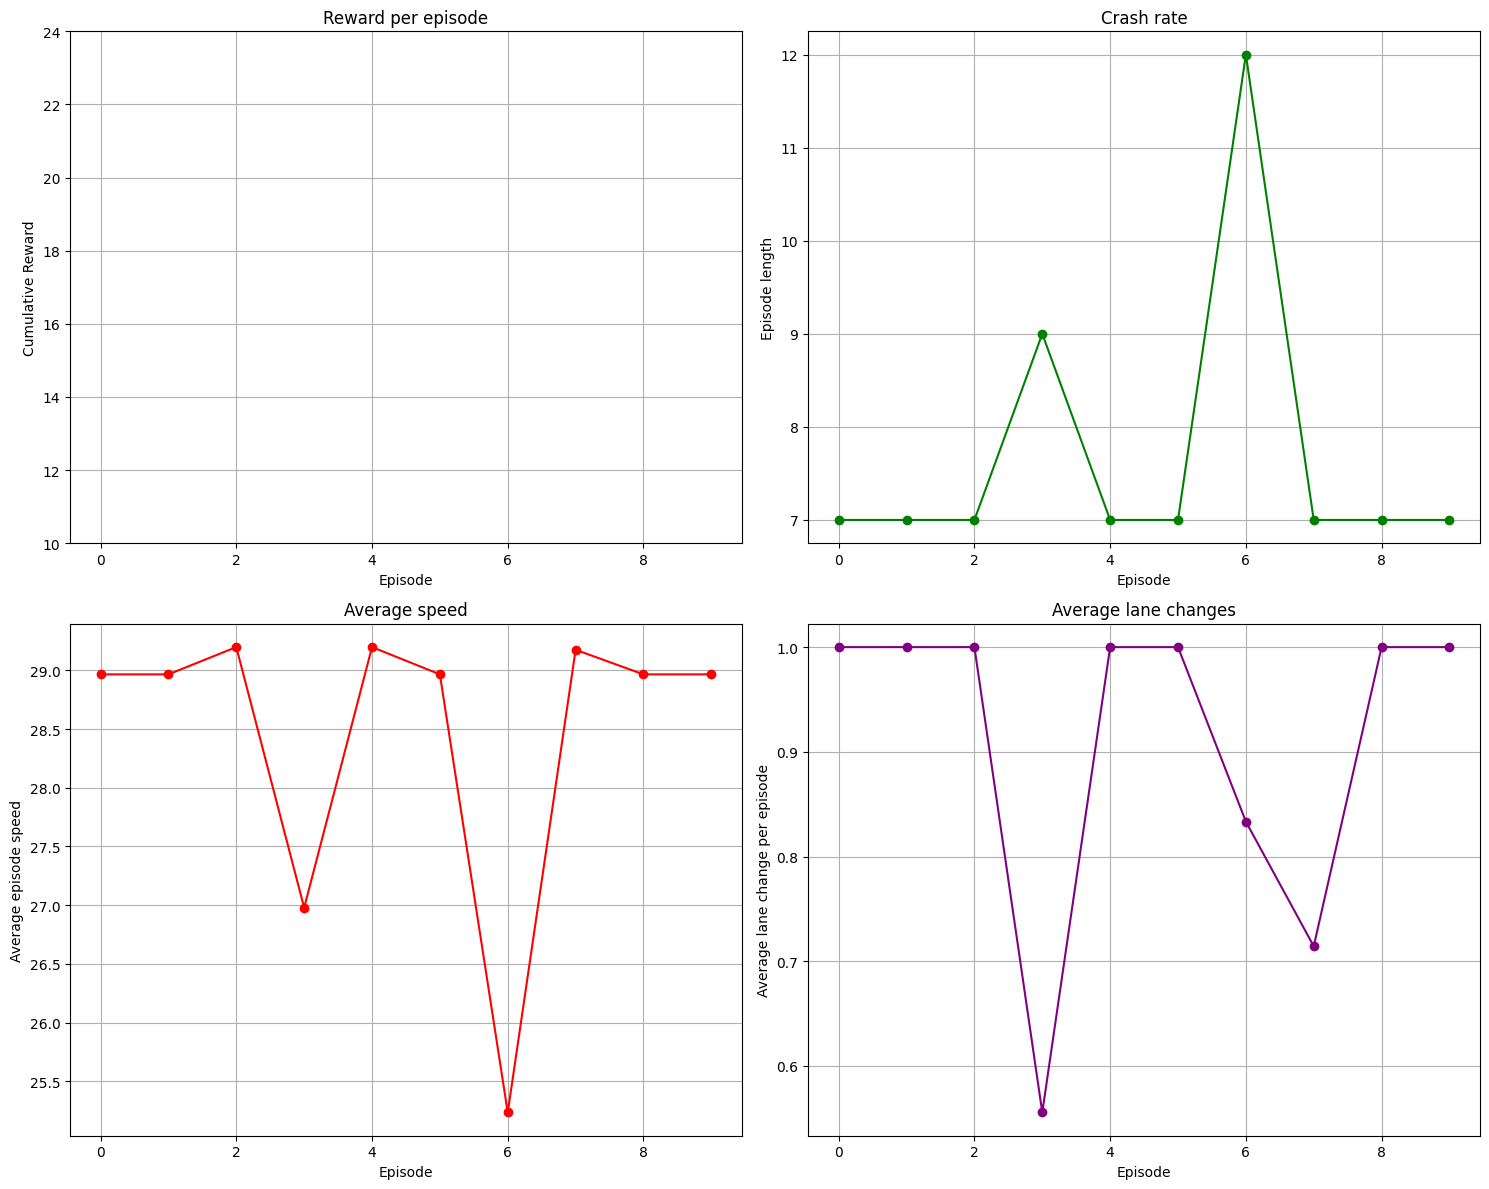

In [47]:
from matplotlib import pyplot as plt 
safety_critical_events = len([value for value in reward_dict.values() if value > 20])
print(f"Number of safety-critical events: {(safety_critical_events)}")
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plotting Learning Curve
axs[0, 0].plot(list(reward_dict.keys()), list(reward_dict.values()), marker='o', color='blue')
axs[0, 0].set_title('Reward per episode')
axs[0, 0].set_xlabel('Episode')
axs[0, 0].set_ylabel('Cumulative Reward')
axs[0, 0].grid(True)
#axs[0, 0].set_xlim(1, 30)  # Set x-axis limits
axs[0, 0].set_ylim(10, 24)  # Set y-axis limits

# Plotting Crash rate
axs[0, 1].plot(list(episode_len_dict.keys()), list(episode_len_dict.values()), marker='o', color='green')
axs[0, 1].set_title('Crash rate')
axs[0, 1].set_xlabel('Episode')
axs[0, 1].set_ylabel('Episode length')
axs[0, 1].grid(True)

# Plotting average speed
axs[1, 0].plot(list(speed_dict.keys()), list(speed_dict.values()), marker='o', color='red')
axs[1, 0].set_title('Average speed')
axs[1, 0].set_xlabel('Episode')
axs[1, 0].set_ylabel('Average episode speed')
axs[1, 0].grid(True)

# Plotting average lane change
axs[1, 1].plot(list(lane_dict.keys()), list(lane_dict.values()), marker='o', color='purple')
axs[1, 1].set_title('Average lane changes')
axs[1, 1].set_xlabel('Episode')
axs[1, 1].set_ylabel('Average lane change per episode')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

